# CANET

In [ ]:
!pip install keras==2.3.1
!pip install -U segmentation-models
! pip install -U albumentations

     |████████████████████████████████| 377 kB 13.8 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 98 kB 6.1 MB/s 
     |████████████████████████████████| 37.1 MB 81 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [41]:
### lOADING THE REQUIRED LIBRARIES
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
import re
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import os
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.augmentations import geometric

In [42]:
import tensorflow as tf
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')

from segmentation_models.metrics import iou_score
import imgaug.augmenters as iaa
from albumentations.augmentations.transforms import PadIfNeeded 
from google.colab.patches import cv2_imshow

env: SM_FRAMEWORK=tf.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### LOADING THE IMAGE PATH

In [43]:
data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ass-26/df.csv",index_col = [0])
data_df["images"]= "/content/drive/MyDrive/Colab Notebooks/ass-26/" + data_df["images"].values
data_df["json"] = "/content/drive/MyDrive/Colab Notebooks/ass-26/" + data_df["json"].values
data_df["mask"] = "/content/drive/MyDrive/Colab Notebooks/ass-26/" + pd.DataFrame(data_df["mask"].values).values
data_df.head()

,images,json,mask
0,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...
1,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...
2,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...
3,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...
4,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...,/content/drive/MyDrive/Colab Notebooks/ass-26/...


## SPLITTING INTO TRAIN AND TEST

In [45]:
df_train , df_test = train_test_split(data_df,test_size=0.2, random_state=30)

In [46]:
'''THIS CELL COMPUTES THE NAMES OF UNIQUE 21 CLASSED OUT OF TOTAL 40 CLASSES'''
# HERE ARE SELECTING THE FIRST CLASS OUT OF ALL THOSE CLASSES WHICH HAS THE SAME COLOR CODING

label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

unique_classes = [] # STORING THE UNIQUE CLASSES IN A LIST 
for i in label_clr.keys(): # FOR EACH CLASS IN THE DICTIONARY LABEL_CLR 
    
    # IF THE LENGTH OF "unique_classes" IS GREATER THAN 1 
    if len(unique_classes)>1:
        # THEN COMPARE THE LAST PRESENT CLASS WITH THE PRESENT CLASS
        # IF THE COLOR OF BOTH IS SAME
        if label_clr[i]==label_clr[unique_classes[-1]]:
            # THEN CONTINUE
            continue
        else:
        # OTHERWISE APPEND THE CLASS TO "unique_classes"
            unique_classes.append(i)
    else:
        # IF THE LENGTH OF LIST "unique_classes" IS ZERO
        unique_classes.append(i)

In [47]:
'''THIS CLASSES FORM THE DATASET'''
class dataset():
    label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
    def __init__(self,df,classes,augmentation):
        self.image = df.images.values #STORING THE PATH OF THE IMAGES
        self.mask = df["mask"].values# STORIN THE PATH OF MASKS
        self.classes =  [self.label_clr.get(i) for i in classes] # STORING THE CLASS COLOR
        self.aug = augmentation # INITIALIZING THE AUGMENTATIONS
       
    # THIS METHOD READS AND APPLY IMAGE AUGMENTATION TO THE IMAGE AND MASK     
    def __getitem__(self,i):
        # READING THE IMAGE 
        image=cv2.imread(self.image[i],cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.float32(cv2.resize(image,(512,512),interpolation=cv2.INTER_AREA)/255)
        
        # READING THE MASK
        mask  = cv2.imread(self.mask[i],cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask,(512,512),interpolation=cv2.INTER_AREA)
        
        # CONVERING 3 CHANNELED IMAGE TO 21 CHANNELS WHERE EACH CHANNEL REPRESENTS THE EACH CLASS
        mask = [(mask==v) for v in self.classes]
        # STACKING THE IMAGE
        mask = np.stack(mask,axis=-1).astype('float32')
         
        # APPLYING THE IMAGE AUGMENTATION TO IMAGES AND MASK 
        image_aug = self.aug(image=image,mask=mask)
        image = image_aug["image"]
        mask= image_aug["mask"]
        
        # RETURNING THE IMAGE AND MASK
        return image, mask
    
    # THIS METHOD RETURNS THE LENGTH OF IMAGE
    def __len__(self):
        return len(self.image)

'''THIS FUNCTION APPLIES AUGMENTATION ON TRAIN DATA'''
def train_aug():
    transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
                A.RandomBrightnessContrast(p=0.2),
                ])
    return transform

'''THIS FUNCNTION APPLIES AUGMENTATION ON TEST DATA'''
def test_aug():
    transform = A.Compose([ # NOT APPLYIN ANY AUGMENTATION FOR TEST DATASET
    ])
    return transform

In [48]:
'''THIS CLASS CONVERTS THE DATASET TO BATCHES'''

class dataloader(tf.keras.utils.Sequence):
    
    def __init__(self,dataset,batch_size,shuffle=False):
        
        # INITIALIZING THE VARIABLES
        self.dataset = dataset
        self.batch_size= batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
    
    # THIS METHOD RETURNS THE DATASET INTO BATCHES
    def __getitem__(self,i):
        
        start = i* self.batch_size # INDEX FOR START OF BATCH 
        stop = (i+1)* self.batch_size # INDEX OF ENDING OF BATCH
        
        batch_x= [] # LIST FOR STORING INPUT BATCH
        batch_y = [] # LIST FOR STORIN OUTPUT BATCH
        
        # FOR EACH BATCH 
        for j in range(start,stop):
            x,y  = self.dataset[j] #GETTING THE jTH INDEX FORM DATASET
            batch_x.append(x) # APPENDING INPUT TO "batch_x"
            batch_y.append(y) # APPENDING TARGET TO "batch_y"
        
        #STACKING THE VALUES OF BATCHED X AND Y
        batch_x = np.stack(batch_x,axis=0)
        batch_y = np.stack(batch_y,axis=0)

        # RETURNING THE BATCH OF X AND Y
        return batch_x,batch_y
    
    # THIS METHOD RETURNS THE NUMBER OF STEPS
    def __len__(self):
        return len(self.indexes)//self.batch_size
    
    # THIS METHOD SHUFFLES THE DATASET
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [49]:
# TRAIN DATASET
train_dataset2 = dataset(df_train, classes=unique_classes, augmentation=train_aug())
# TEST DATASET
test_dataset2 = dataset(df_test, classes=unique_classes, augmentation=test_aug())

# TRAIN DATALOADER
train_dataloader2 = dataloader(train_dataset2,16,True)
# TEST DATALOADER
test_dataloader2 = dataloader(test_dataset2,16,False)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [30]:
'''THIS CELL FORMS THE CLASS FOR CONVOLUTION BLOCK'''

class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, strides,filters=[4,4,8], name="conv_block"):
        super().__init__(name=name)
        self.strides = strides
        self.F1, self.F2, self.F3 = filters
        
        self.conv1 = layers.Conv2D(filters=self.F1,kernel_size=(1,1),strides=(self.strides,self.strides),kernel_initializer='glorot_uniform')
        self.conv2 = layers.Conv2D(filters=self.F2,kernel_size= (3,3),padding = "same",kernel_initializer='glorot_uniform')
        self.conv3 = layers.Conv2D(filters=self.F3,kernel_size= (1,1),kernel_initializer='glorot_uniform')
        self.conv4 = layers.Conv2D(filters=self.F3,kernel_size= (3,3),strides=(self.strides,self.strides),padding = "same",kernel_initializer='glorot_uniform')
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()

    def call(self, X):
        # write the architecutre that was mentioned above
        X_intial = X

        X1 = self.conv1(X)
        X1 = self.bn1(X1)
        X1 = layers.Activation("relu")(X1)
        
        X1 = self.conv2(X1)
        X1= self.bn2(X1)
        X1= layers.Activation("relu")(X1)
        
       
        X1 = self.conv3(X1)
        X1= self.bn3(X1)
        
        X2 = self.conv4(X_intial)
        X2= self.bn4(X2)
        X2= layers.Activation("relu")(X2)
        
        X_final = layers.Add()([X1,X2])
        X_final = layers.Activation("relu")(X_final)
        
        return X_final

In [31]:
'''THIS CELL FORMS THE CLASS FOR IDENTITY BLOCK'''

class identity_block(tf.keras.layers.Layer):
    def __init__(self,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        
        self.F1, self.F2, self.F3 = filters

        self.conv1 = layers.Conv2D(filters=self.F1,kernel_size=(1,1),kernel_initializer='glorot_uniform')
        self.conv2 = layers.Conv2D(filters=self.F2,kernel_size= (3,3),padding="same",kernel_initializer='glorot_uniform')
        self.conv3 = layers.Conv2D(filters=self.F3,kernel_size= (1,1),kernel_initializer='glorot_uniform')
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        
    def call(self, X):
        # write the architecutre that was mentioned above
        X_initial = X

        X1 = self.conv1(X)
        X1=  self.bn1(X1)
        X1= layers.Activation("relu")(X1)
        
        X1 = self.conv2(X1)
        X1= self.bn2(X1)
        X1= layers.Activation("relu")(X1)
       
        X1 = self.conv3(X1)
        X1= self.bn3(X1)
        
        X_final = layers.Add()([X_initial,X1])
        X_final = layers.Activation("relu")(X_final)
        
        
        return X_final

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [32]:
'''THIS CELL FORMS THE CLASS FOR GLOBAL FLOW'''

class global_flow(tf.keras.layers.Layer):
    def __init__(self, n_value ,name="global_flow"):
        super().__init__(name=name)
        self.n = n_value
        
    def build(self,input_shape):
        self.upsampling =  input_shape[1:-1]
        self.filters =  input_shape[-1]

        self.ap = layers.AveragePooling2D(1,self.upsampling)
        self.bn = layers.BatchNormalization()
        self.activation = layers.Activation("relu")
        self.conv1 = layers.Conv2D(filters= self.filters,kernel_size = (1,1),activation="relu",kernel_initializer='glorot_uniform')
        self.upsamp   = layers.Conv2DTranspose(int(self.filters/self.n),self.upsampling)
    
    def call(self, X):
        
        X = self.ap(X)
        X = self.bn(X)
        X = self.activation(X)
        X = self.conv1(X)
        
        X = self.upsamp(X)
        
        return X

In [33]:
'''THIS CELL FORMS THE CLASS FOR CONTEXT FLOW'''

class context_flow(tf.keras.layers.Layer):

    def __init__(self, n_value,name="context_flow"):
        super().__init__(name=name)
        self.n = n_value
        
    def build(self,input_shape):
        self.filters =  int(input_shape[0][-1]/self.n)

        self.conv1 = layers.Conv2D(filters = self.filters,kernel_size = (3,3),padding="same",activation="relu",kernel_initializer='glorot_uniform')
        self.conv2 = layers.Conv2D(filters = self.filters,kernel_size=(3,3),padding="same",activation="relu",kernel_initializer='glorot_uniform')
        self.conv3 = layers.Conv2D(filters= self.filters, kernel_size= (1,1),activation="relu",kernel_initializer='glorot_uniform')
        self.conv4 = layers.Conv2D(filters= self.filters, kernel_size= (1,1),activation="relu",kernel_initializer='glorot_uniform')

        self.upsamp = layers.Conv2DTranspose(32,kernel_size=(33,33))

        
    def call(self, X):

        INP, FLOW = X[0], X[1] 
        con1 = layers.Concatenate(axis=-1)([INP,FLOW])
        con1 = layers.AveragePooling2D(pool_size=(self.n,self.n),strides=(self.n,self.n))(con1)
        con1 = self.conv1(con1)
        con1 = self.conv2(con1)
  
        con2 = self.conv3(con1)
        con2 = layers.Activation("relu")(con2)
        con2 = self.conv4(con2)
        con2 = layers.Activation("sigmoid")(con2)
        
        con3 = layers.Multiply()([con1,con2])
        
        con3 = layers.Add()([con1,con3])
        
      
        con3 = self.upsamp(con3)
        
        return con3

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [39]:
'''THIS CELL FORMS THE CLASS FOR FEATURE SELECTION MODEL'''
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
    def build(self,input_shape):
        self.inp = input_shape[1:-1]
        self.filters = input_shape[-1]
        
        self.conv1 = layers.Conv2D(filters= self.filters,kernel_size=(3,3),padding = "same" ,activation= "relu",kernel_initializer='glorot_uniform')
        self.conv2 = layers.Conv2D(filters = self.filters,kernel_size = (1,1),activation= "relu",kernel_initializer='glorot_uniform')
        self.bn = layers.BatchNormalization()
        self.ap= layers.AveragePooling2D(1, self.inp )

    def call(self, X):
        
        con1 = self.conv1(X)
        
        con2 = self.ap(con1)
        
        con2 = self.conv2(con2)
        con2 = self.bn(con2)
        con2 = layers.Activation("sigmoid")(con2)
        
        con3 = layers.Multiply()([con1,con2])
        
        
        return con3

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [35]:
'''THIS CELL FORMS THE CLASS FOR AGCN'''
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
    def build(self,input_shape):
        self.filters = input_shape[-1]
        self.conv1 = layers.Conv2D(filters=self.filters,kernel_size=(7,1),padding="same",activation="relu",kernel_initializer='glorot_uniform')
        self.conv2 = layers.Conv2D(filters=self.filters,kernel_size=(1,7),padding="same",activation="relu",kernel_initializer='glorot_uniform')
        self.conv3 = layers.Conv2D(filters=self.filters,kernel_size=(1,7),padding="same",activation="relu",kernel_initializer='glorot_uniform')
        self.conv4 = layers.Conv2D(filters=self.filters,kernel_size=(7,1),padding="same",activation="relu",kernel_initializer='glorot_uniform')
        self.conv5 = layers.Conv2D(filters=self.filters,kernel_size= (3,3),padding = "same",activation="relu",kernel_initializer='glorot_uniform')

    def call(self, X):
        con1 = self.conv1(X)
        con1 = self.conv2(con1)
        
        con2 = self.conv3(X)
        con2 = self.conv4(con2)
        
        con3 = layers.Add()([con1,con2])
        
        con4 = self.conv5(con3)
        
        con5 = layers.Add()([con3,con4])
        
        return con5

In [50]:
'''THIS CELL HOLDS THE COMPLETHE ARCHITECTURE FOR THE CANET MODEL'''

X_input = layers.Input(shape=(512,512,3))

# Stage 1
X = layers.Conv2D(64, (3, 3), name='conv1', padding="same")(X_input)
X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
X = layers.Activation('relu')(X)
X = layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

# C1
ag_input = convolutional_block(strides=2,filters=[4,4,8],name="c1")(X)
c1 = identity_block(filters=[4,4,8],name="identity_c1_1")(ag_input)

# C2
c2 = convolutional_block(strides=2,filters=[8,8,16],name="c2")(c1)
c2 = identity_block(filters=[8,8,16],name = "identity_c2_1")(c2)
c2 = identity_block(filters=[8,8,16],name = "identity_c2_2")(c2)
c2 = identity_block(filters=[8,8,16],name = "identity_c2_3")(c2)

# C3
c3 = convolutional_block(strides=1,filters=[16,16,32],name="c3")(c2)
c3 = identity_block(filters=[16,16,32],name = "identity_c3_1")(c3)
c3 = identity_block(filters=[16,16,32],name = "identity_c3_2")(c3)
c3 = identity_block(filters=[16,16,32],name = "identity_c3_3")(c3)
c3 = identity_block(filters=[16,16,32],name = "identity_c3_4")(c3)
# C4
c4 = convolutional_block(strides=1,filters=[32,32,64],name="c4")(c3)
c4 = identity_block(filters=[32,32,64],name = "identity_c4_1")(c4)
c4 = identity_block(filters=[32,32,64],name = "identity_c4_2")(c4)
c4 = identity_block(filters=[32,32,64],name = "identity_c4_3")(c4)
c4 = identity_block(filters=[32,32,64],name = "identity_c4_4")(c4)
c4 = identity_block(filters=[32,32,64],name = "identity_c4_5")(c4)

global_flow1 = global_flow(n_value = 2)(c4)

context_flow1 = context_flow(2,name="flow1")((c4,global_flow1))

context_flow2 = context_flow(2,name="flow2")((c4,context_flow1))

context_flow3 = context_flow(2,name="flow3")((c4,context_flow2))

sum_all = layers.Add()([global_flow1,context_flow1,context_flow2,context_flow3])

feature_selection = fsm()(sum_all)

adapted_global_conv = agcn()(ag_input)

con1 = layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu")(feature_selection)
upsampling1 = layers.UpSampling2D(size= (2,2),interpolation="bilinear")(con1)
concat = layers.Concatenate()([upsampling1, adapted_global_conv])

final = layers.Conv2D(filters=21,kernel_size=(3,3),padding = "same",activation="relu")(concat)

final = layers.UpSampling2D(size=(4,4),interpolation = "bilinear")(final)

soft = layers.Activation("softmax")(final)

model = Model(inputs = X_input, outputs = soft)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_68 (Activation)      (None, 512, 512, 64) 0           bn_conv1[0][0]                   
____________________________________________________________________________________________

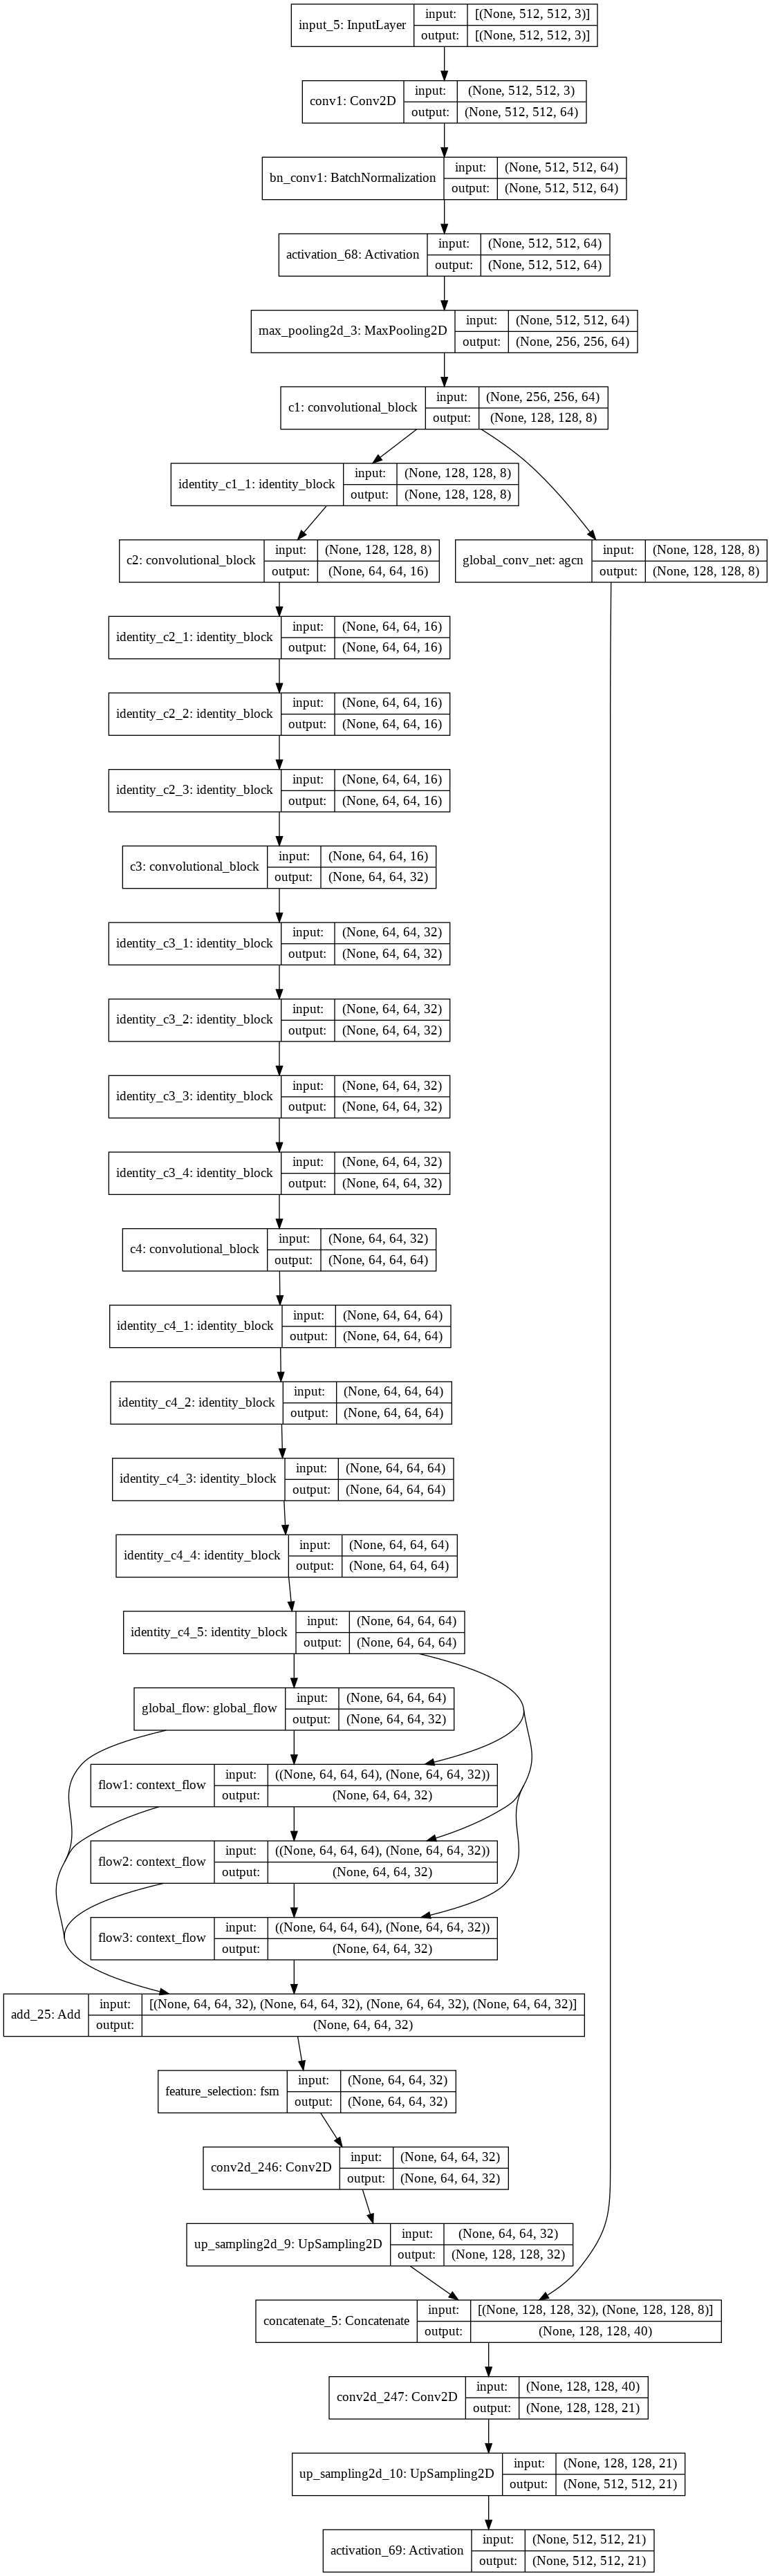

In [52]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [18]:
callback = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5',save_best_only=True,save_weights_only=True,mode="min",verbose=1),
            
            tf.keras.callbacks.TensorBoard('/content/drive/MyDrive/Colab Notebooks/ass-26/save2/logs/save',histogram_freq=1)
            
] 
train_steps2 = train_dataloader2.__len__()
test_steps2 = test_dataloader2.__len__()
model.compile(tf.keras.optimizers.Adam(0.0003), sm.losses.cce_dice_loss , metrics=[iou_score])
model.load_weights('/content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5')

In [ ]:
history = model.fit(train_dataloader2 ,epochs=20,steps_per_epoch =train_steps2 ,validation_data=test_dataloader2,validation_steps=test_steps2,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
200/200 [==============================] - 2538s 13s/step - loss: 0.7994 - iou_score: 0.1796 - val_loss: 0.8946 - val_iou_score: 0.1398
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
200/200 [==============================] - 591s 3s/step - loss: 0.7969 - iou_score: 0.1809 - val_loss: 0.8088 - val_iou_score: 0.1834
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
200/200 [==============================] - 603s 3s/step - loss: 0.7839 - iou_score: 0.1897 - val_loss: 0.8096 - val_iou_score: 0.1853
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
200/200 [==============================] - 598s 3s/step - loss: 0.7749 - iou_score: 0.1949 - val_loss: 0.7645 - val_iou_score: 0.2072
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000

In [ ]:
history = model.fit(train_dataloader2 ,epochs=20,steps_per_epoch =train_steps2 ,validation_data=test_dataloader2,validation_steps=test_steps2,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
200/200 [==============================] - 541s 3s/step - loss: 0.6548 - iou_score: 0.2863 - val_loss: 0.6460 - val_iou_score: 0.2991

Epoch 00001: val_loss improved from 0.65205 to 0.64601, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 2/20
200/200 [==============================] - 543s 3s/step - loss: 0.6519 - iou_score: 0.2883 - val_loss: 0.6645 - val_iou_score: 0.2844

Epoch 00002: val_loss did not improve from 0.64601
Epoch 3/20
200/200 [==============================] - 541s 3s/step - loss: 0.6501 - iou_score: 0.2894 - val_loss: 0.6727 - val_iou_score: 0.2797

Epoch 00003: val_loss did not improve from 0.64601
Epoch 4/20
200/200 [==============================] - 542s 3s/step - loss: 0.6485 - iou_score: 0.2912 - val_loss: 0.6496 - val_iou_score: 0.2952

Epoch 00004: val_loss did not improve from 0.64601
Epoch 5/20
200/200 [==============================] - 543s 3s/step - loss: 0.6504 - iou_score: 0.2894 - val_loss: 0.6614 - val_iou_

In [ ]:
history = model.fit(train_dataloader2 ,epochs=20,steps_per_epoch =train_steps2 ,validation_data=test_dataloader2,validation_steps=test_steps2,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
200/200 [==============================] - 4880s 24s/step - loss: 0.6197 - iou_score: 0.3150 - val_loss: 0.6321 - val_iou_score: 0.3116

Epoch 00001: val_loss improved from inf to 0.63211, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 2/20
200/200 [==============================] - 515s 3s/step - loss: 0.6184 - iou_score: 0.3160 - val_loss: 0.6199 - val_iou_score: 0.3200

Epoch 00002: val_loss improved from 0.63211 to 0.61993, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 3/20
200/200 [==============================] - 520s 3s/step - loss: 0.6168 - iou_score: 0.3175 - val_loss: 0.6271 - val_iou_score: 0.3135

Epoch 00003: val_loss did not improve from 0.61993
Epoch 4/20
200/200 [==============================] - 522s 3s/step - loss: 0.6160 - iou_score: 0.3178 - val_loss: 0.6309 - val_iou_score: 0.3145

Epoch 00004: val_loss did not improve from 0.61993
Epoch 5/20
200/200 [==============================] 

In [ ]:
history = model.fit(train_dataloader2 ,epochs=20,steps_per_epoch =train_steps2 ,validation_data=test_dataloader2,validation_steps=test_steps2,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
200/200 [==============================] - 5059s 25s/step - loss: 0.6074 - iou_score: 0.3257 - val_loss: 0.6118 - val_iou_score: 0.3289

Epoch 00001: val_loss improved from inf to 0.61184, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 2/20
200/200 [==============================] - 510s 3s/step - loss: 0.6023 - iou_score: 0.3299 - val_loss: 0.6141 - val_iou_score: 0.3276

Epoch 00002: val_loss did not improve from 0.61184
Epoch 3/20
200/200 [==============================] - 512s 3s/step - loss: 0.6040 - iou_score: 0.3286 - val_loss: 0.6196 - val_iou_score: 0.3243

Epoch 00003: val_loss did not improve from 0.61184
Epoch 4/20
200/200 [==============================] - 510s 3s/step - loss: 0.6015 - iou_score: 0.3309 - val_loss: 0.6089 - val_iou_score: 0.3305

Epoch 00004: val_loss improved from 0.61184 to 0.60890, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 5/20
200/200 [==============================] 

In [ ]:
history = model.fit(train_dataloader2 ,epochs=20,steps_per_epoch =train_steps2 ,validation_data=test_dataloader2,validation_steps=test_steps2,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
200/200 [==============================] - 3390s 17s/step - loss: 0.5854 - iou_score: 0.3450 - val_loss: 0.5936 - val_iou_score: 0.3428

Epoch 00001: val_loss improved from inf to 0.59355, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 2/20
200/200 [==============================] - 591s 3s/step - loss: 0.5861 - iou_score: 0.3444 - val_loss: 0.5935 - val_iou_score: 0.3463

Epoch 00002: val_loss improved from 0.59355 to 0.59349, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 3/20
200/200 [==============================] - 592s 3s/step - loss: 0.5832 - iou_score: 0.3468 - val_loss: 0.5914 - val_iou_score: 0.3458

Epoch 00003: val_loss improved from 0.59349 to 0.59139, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 4/20
200/200 [==============================] - 577s 3s/step - loss: 0.5851 - iou_score: 0.3453 - val_loss: 0.5939 - val_iou_score: 0.3440

Epoch 00004: val_loss 

In [ ]:
history = model.fit(train_dataloader2 ,epochs=40,steps_per_epoch =train_steps2 ,validation_data=test_dataloader2,validation_steps=test_steps2,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/40
200/200 [==============================] - 6774s 34s/step - loss: 0.5753 - iou_score: 0.3542 - val_loss: 0.5883 - val_iou_score: 0.3511

Epoch 00001: val_loss improved from inf to 0.58828, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 2/40
200/200 [==============================] - 505s 3s/step - loss: 0.5716 - iou_score: 0.3575 - val_loss: 0.5820 - val_iou_score: 0.3553

Epoch 00002: val_loss improved from 0.58828 to 0.58200, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 3/40
200/200 [==============================] - 515s 3s/step - loss: 0.5737 - iou_score: 0.3556 - val_loss: 0.5820 - val_iou_score: 0.3541

Epoch 00003: val_loss improved from 0.58200 to 0.58195, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 4/40
200/200 [==============================] - 514s 3s/step - loss: 0.5725 - iou_score: 0.3564 - val_loss: 0.5952 - val_iou_score: 0.3450

Epoch 00004: val_loss 

In [ ]:
history = model.fit(train_dataloader2 ,epochs=40,steps_per_epoch =train_steps2 ,validation_data=test_dataloader2,validation_steps=test_steps2,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/40
200/200 [==============================] - 5010s 25s/step - loss: 0.5455 - iou_score: 0.3812 - val_loss: 0.5698 - val_iou_score: 0.3673

Epoch 00001: val_loss improved from inf to 0.56979, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 2/40
200/200 [==============================] - 540s 3s/step - loss: 0.5434 - iou_score: 0.3832 - val_loss: 0.5609 - val_iou_score: 0.3727

Epoch 00002: val_loss improved from 0.56979 to 0.56090, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 3/40
200/200 [==============================] - 547s 3s/step - loss: 0.5467 - iou_score: 0.3796 - val_loss: 0.5570 - val_iou_score: 0.3769

Epoch 00003: val_loss improved from 0.56090 to 0.55702, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 4/40
200/200 [==============================] - 547s 3s/step - loss: 0.5463 - iou_score: 0.3804 - val_loss: 0.5645 - val_iou_score: 0.3710

Epoch 00004: val_loss 

In [ ]:
history = model.fit(train_dataloader2 ,epochs=40,steps_per_epoch =train_steps2 ,validation_data=test_dataloader2,validation_steps=test_steps2,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/40
200/200 [==============================] - 2724s 14s/step - loss: 0.5333 - iou_score: 0.3925 - val_loss: 0.5689 - val_iou_score: 0.3667

Epoch 00001: val_loss improved from inf to 0.56887, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 2/40
200/200 [==============================] - 505s 3s/step - loss: 0.5310 - iou_score: 0.3949 - val_loss: 0.5639 - val_iou_score: 0.3721

Epoch 00002: val_loss improved from 0.56887 to 0.56391, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 3/40
200/200 [==============================] - 518s 3s/step - loss: 0.5307 - iou_score: 0.3948 - val_loss: 0.5625 - val_iou_score: 0.3749

Epoch 00003: val_loss improved from 0.56391 to 0.56249, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 4/40
200/200 [==============================] - 519s 3s/step - loss: 0.5285 - iou_score: 0.3971 - val_loss: 0.5520 - val_iou_score: 0.3828

Epoch 00004: val_loss 

In [ ]:
history = model.fit(train_dataloader2 ,epochs=40,steps_per_epoch =train_steps2 ,validation_data=test_dataloader2,validation_steps=test_steps2,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/40
200/200 [==============================] - 3447s 17s/step - loss: 0.5138 - iou_score: 0.4107 - val_loss: 0.5357 - val_iou_score: 0.3970

Epoch 00001: val_loss improved from inf to 0.53566, saving model to /content/drive/MyDrive/Colab Notebooks/ass-26/save2/test.h5
Epoch 2/40
200/200 [==============================] - 536s 3s/step - loss: 0.5121 - iou_score: 0.4126 - val_loss: 0.5393 - val_iou_score: 0.3943

Epoch 00002: val_loss did not improve from 0.53566
Epoch 3/40
200/200 [==============================] - 536s 3s/step - loss: 0.5118 - iou_score: 0.4133 - val_loss: 0.5418 - val_iou_score: 0.3922

Epoch 00003: val_loss did not improve from 0.53566
Epoch 4/40
200/200 [==============================] - 527s 3s/step - loss: 0.5105 - iou_score: 0.4141 - val_loss: 0.5379 - val_iou_score: 0.3958

Epoch 00004: val_loss did not improve from 0.53566
Epoch 5/40
200/200 [==============================] - 526s 3s/step - loss: 0.5111 - iou_score: 0.4138 - val_loss: 0.5377 - val_iou_sc

KeyboardInterrupt: ignored

## Evaluation of Validation Score

In [ ]:
model.evaluate(test_dataloader2)

50/50 [==============================] - 961s 19s/step - loss: 0.5336 - iou_score: 0.4002


[0.5335870981216431, 0.4001671075820923]

## Generating Output Images

In [24]:
'''NEW COLORS FOR OUTPUT'''
label_clr2 = {'road':[128, 64, 128], 'parking':[250, 170, 160], 'drivable fallback':[250, 170, 160],'sidewalk': [244, 35, 232] ,'non-drivable fallback':[156, 60, 200],'rail track':[156, 60, 200],\
                        'person':[220, 20, 60], 'animal':[220, 20, 60], 'rider':[255, 0, 0], 'motorcycle':[0, 0, 230], 'bicycle':[0, 0, 230], 'autorickshaw':[99, 250, 80],\
                        'car':[99, 250, 80], 'truck': [0, 0, 70], 'bus': [0, 0, 70], 'vehicle fallback': [0, 0, 70], 'trailer': [0, 0, 70], 'caravan': [0, 0, 70],\
                        'curb': [196, 209, 152], 'wall': [196, 209, 152], 'fence':[190, 153, 153],'guard rail':[190, 153, 153], 'billboard':[250, 170, 30],'traffic sign':[250, 170, 30],\
                        'traffic light':[250, 170, 30], 'pole':[153, 153, 153], 'polegroup':[153, 153, 153], 'obs-str-bar-fallback':[153, 153, 153],'building': [70, 70, 70],\
                        'bridge': [70, 70, 70],'tunnel': [70, 70, 70], 'vegetation':[107, 142, 35], 'sky':[70, 130, 180], 'fallback background':[70, 130, 180],'unlabeled':[0,0,0],\
                        'out of roi':[0,0,0], 'ego vehicle':[10, 100, 200], 'ground':[82, 92, 214],'rectification border':[89, 202, 34],\
                   'train':[35, 105, 70]}

In [28]:
'''THIS FUNCTION PREDICTS THE OUTPUT FROM THE MODEL AND PLOTS THE OUTPUT'''
def prediction(input_img , output_img):
    # CREATING ZEROS ARRAY FOR PREDICTIONS
    pred_img = np.zeros(shape=(512,512,3))
     # PREDICT THE RESULS OF MODEL
    pred = model.predict(input_img).round(1)
     # ACTUAL TARGET IMAGE
    actual = output_img
     # CREATING ZEROS ARRAY FOR ACTUAL TARGETS
    actual_img = np.zeros(shape=(512,512,3))
    
     # THE PREDICTIONS AND TARGET IMAGE ARE 21 CHANNELS WE HAVE TO CONVERT IT TO 3 CHANNELS
    for i in range(21):
        
        # COPYING EACH CHANNEL OF PREDICTIONS(1080,1920) THREE TIMES AND ADDING TO THE "pred_img" 
        x = np.zeros((512,512,3))
        x[:,:,0] = pred[0,:,:,i]*label_clr2[unique_classes[i]][0]
        x[:,:,1] = pred[0,:,:,i]* label_clr2[unique_classes[i]][1]
        x[:,:,2] = pred[0,:,:,i]*label_clr2[unique_classes[i]][2]
        
        pred_img+= x
        
        # COPYING EACH CHANNEL OF PREDICTIONS(1080,1920) THREE TIMES AND ADDING TO THE "actual_img" 
        y = np.zeros((512,512,3))
        y[:,:,0] = actual[0,:,:,i]*label_clr2[unique_classes[i]][0]
        y[:,:,1] = actual[0,:,:,i]* label_clr2[unique_classes[i]][1]
        y[:,:,2] = actual[0,:,:,i]*label_clr2[unique_classes[i]][2]
        actual_img +=y
        
    # PLOTTING THE ORIGINAL IMAGE
    plt.figure(figsize = (16,10))
    plt.subplot(1,3,1)
    plt.title("Actual Image")
    plt.imshow(input_img[0])   
    plt.xticks([])
    plt.yticks([])
    
    # PLOTTING THE TARGET IMAGE
    plt.subplot(1,3,2)
    plt.title("Target Segmentation")
    plt.imshow(actual_img.astype(np.uint8))   
    plt.xticks([])
    plt.yticks([])
    
     # PLOTTING THE PREDICTED SEGMENTED IMAGE
    plt.subplot(1,3,3)
    plt.title("Predicted Segmentation")
    plt.imshow(pred_img.astype(np.uint8)) 
    plt.xticks([])
    plt.yticks([])  
    plt.show()

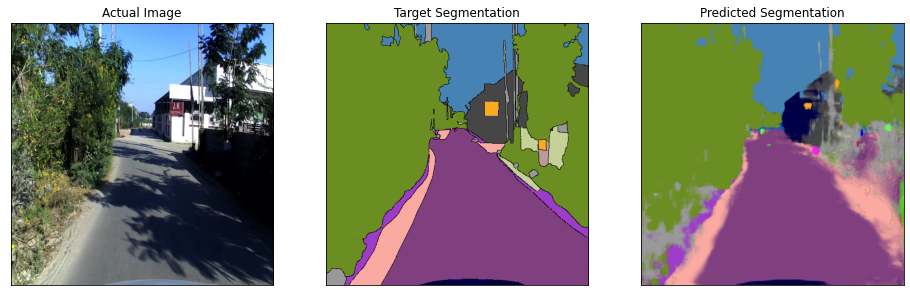

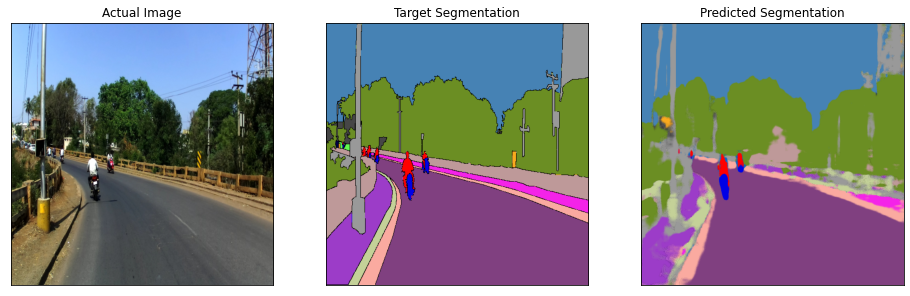

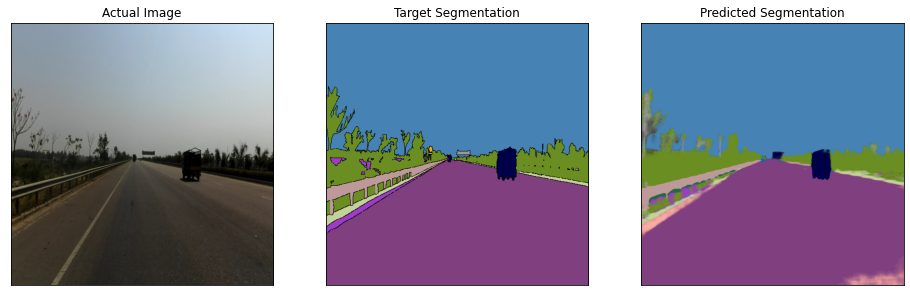

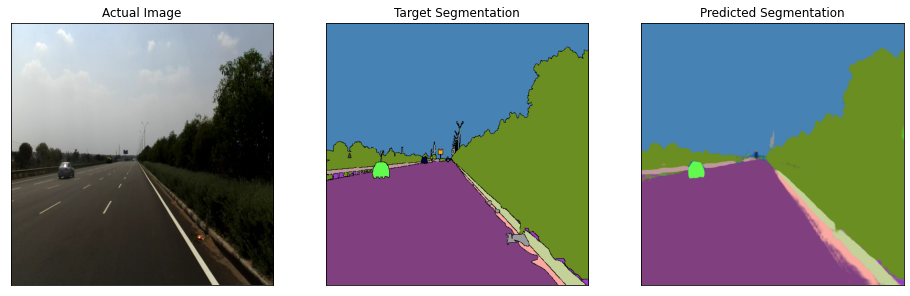

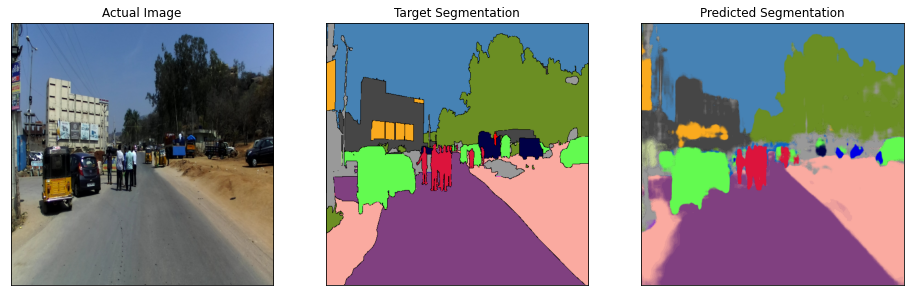

In [29]:
for i in range(5):
   prediction(test_dataloader2[i][0],test_dataloader2[i][1])

## Observations:
* The model is performing fine at this given values of validation score.
* It could be further improved by performing the more training on better hardwares.